# Feature Detection and Description 

### 1. Understanding Features

- One of the features that is useful for identifying images is corners because when you take a corner it is much easier to determine where the corner belongs to in the image compared to a flat surface or even an edge. 

- Feature Detection is finding the features of an image.

- Feature Description is the description of the region around the feature so that it can be used to find it in other images. 

### 2. Harris Corner Detection

- One way of defining corners in the image is that it was regions in the image with large variations in intesnsity in all directions. 

**Harris Corner Detector**

```math 
E(u, v) = \sum_{x, y} w(x, y) [I(x + u, y + v) - I(x, y)]^2
```

- w(x, y) : Window Function
- I(x + u, y + v) : Shifted Intensity
- I(x, y) : Intensity
- The window is a rectangular windor or a Gaussian window which gives to pixels underneath
- Need to maximize the function E(u, v) for corner detection.
- Applying Taylor Expansion 

```math 
E(u, v) = \begin{pmatrix} x & v \end{pmatrix} M\begin{pmatrix} u \\ v \end{pmatrix}
```
where

```math
M = \sum_{x, y} w(x, y)\begin{pmatrix} I_xI_x & I_xI_y \\ I_xI_y & I_yI_y \end{pmatrix}
```

##### Harris Corner Detection in OpenCV

cv.cornerHarris()
- img: input image. Should be grayscale and float32 type
- blockSize: The size of neighborhood considered for corner detection
- ksize: Aperature parameter of the Sobel derivative used
- k : Harris detector free parameter in the equation


In [1]:
import numpy as np 
import cv2 as cv

filename = 'C:\\Users\\steve\\Projects\\Computer_Vision\\datasets\\chessboard.png' # Sets file name
img = cv.imread(filename) # Reads image which loads the image in color by default
gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY) # CV convert color using the img where the second input specify blue-green-red to grayscale
 
gray = np.float32(gray) # Converts grayscale image to float32 datatype from the default uint8. 
dst = cv.cornerHarris(gray,2,3,0.04) # Requires float32 for more precise computations
# 2: The neighborhood size, or the window size around each pixel to calculate gradient
# 3: Aperture parameter of the Sobel derivative used internally for computing gradient
# 0.04: The harris detector free parameter. Typical values are between 0.04 - 0.06
 
#result is dilated for marking the corners, not important
dst = cv.dilate(dst,None) # Dilate the image to make the detected corners more visible. Dilate is a morphological operation that expands bright regions.
 
# Threshold for an optimal value, it may vary depending on the image.
img[dst>0.01*dst.max()]=[0,0,255] # Sets pixels in the original img to red ([0, 0, 225]) where the dst (corner response) values are greater than 1% of the 
# maximum response. 
 
cv.imshow('dst',img) # Displays the image with detected corners marked in red in a window titled 'dst'
if cv.waitKey(0) & 0xff == 27: # If the Esc key is pressed key(27)
    cv.destroyAllWindows()

In [ ]:
filename = 'C:\\Users\\steve\\Projects\\Computer_Vision\\datasets\\chessboard.png'
img = cv.imread(filename)
gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
 
# find Harris corners
gray = np.float32(gray)
dst = cv.cornerHarris(gray,2,3,0.04)
dst = cv.dilate(dst,None)
ret, dst = cv.threshold(dst,0.01*dst.max(),255,0) # Applies a threshold, setting values above 0.01 * dst.max() to 255 and the rest to 0, creating a binary image where corners are highlighted. 
dst = np.uint8(dst)
 
# find centroids
ret, labels, stats, centroids = cv.connectedComponentsWithStats(dst) # Uses connectedComponentsWithStats to find all connected components (corner points) in dst and retrieves their centroids. Each centroid represents the average position of a detected corner.
 
# define the criteria to stop and refine the corners
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 100, 0.001)
corners = cv.cornerSubPix(gray,np.float32(centroids),(5,5),(-1,-1),criteria)
'''
- cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER: Combines two criteria: a maximum of 100 iterations or until the corner position accuracy reaches 0.001.
- (5, 5): The window size around each corner to search within.
- (-1, -1): Specifies that no "dead zone" (region around the corner that won't be refined) is used.
- cornerSubPix refines each centroid location, producing a more accurate corner location.
'''


# Now draw them
res = np.hstack((centroids,corners))
res = np.int0(res)
img[res[:,1],res[:,0]]=[0,0,255]
img[res[:,3],res[:,2]] = [0,255,0]
'''
- Concatenates the original centroids and refined corners into a single array res, where each row contains the coordinates of an original centroid and its corresponding refined corner.
- np.int0(res) converts the array to integer values.
- Draws each original centroid as a red dot ([0, 0, 255]) and each refined corner as a green dot ([0, 255, 0]) on the original image.
'''
 

cv.imwrite('subpixel5.png',img)

C:\Users\steve\AppData\Local\Temp\ipykernel_12676\1544166602.py:21: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  res = np.int0(res)


True

### 3. Shi-Tomasi Corner Detector & Good Features to Track

- Tomasi made a small modification to the Harris Corner Detector specifically in the scoring function. A pixel is considered a corner if minimum eigenvalue exceeds a certain threshold. 

C:\Users\steve\AppData\Local\Temp\ipykernel_12676\1356486225.py:12: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  corners = np.int0(corners)


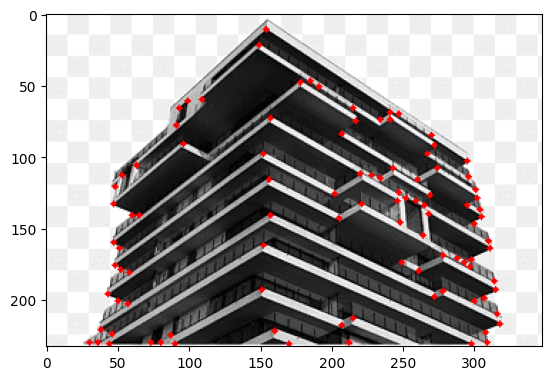

(<matplotlib.image.AxesImage at 0x1d736564640>, None)

In [21]:
from matplotlib import pyplot as plt

img = cv.imread('C:\\Users\\steve\\Projects\\Computer_Vision\\datasets\\building.png')
gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
 
corners = cv.goodFeaturesToTrack(gray,100,0.03,5) 
'''
80: maximum number of corners to detect
0.01: Minimum quality level for corners (lower values allow weaker corners)
10: Minimum distance between detected corners
'''
corners = np.int0(corners)
 
for i in corners:
    x,y = i.ravel()
    cv.circle(img,(x,y),2,300,-1)
# Draws small circle (radius: 3, color 255, thickness: -1)
 
plt.imshow(img),plt.show()

# Function may be more appropriate for tracking

### 4. Introduction to SIFT (Scale-Invariant Feature Transform)

- Review: we seen corner detection that were rotation-invariant meaning even if the image is rotated we can find the same corner. 
- Problem: What if the corner was scaled differently and the window size change because of that. We won't be able to identify some corners. 
- Solution: We use SIFT

In [22]:

img = cv.imread('C:\\Users\\steve\\Projects\\Computer_Vision\\datasets\\building.png')
gray= cv.cvtColor(img,cv.COLOR_BGR2GRAY)
 
sift = cv.SIFT_create()
kp = sift.detect(gray,None)
 
img=cv.drawKeypoints(gray,kp,img)
 
cv.imwrite('sift_keypoints.jpg',img)

True

In [23]:
img=cv.drawKeypoints(gray,kp,img,flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
cv.imwrite('sift_keypoints.jpg',img)

True

In [24]:
sift = cv.SIFT_create()
kp, des = sift.detectAndCompute(gray,None)